# State space modeling: Local Linear Trends

This notebook describes how to extend the statsmodels statespace classes to create and estimate a custom model. Here we develop a local linear trend model.

The Local Linear Trend model has the form (see Durbin and Koopman 2012, Chapter 3.2 for all notation and details):

$$
\begin{align}
y_t & = \mu_t + \varepsilon_t \qquad & \varepsilon_t \sim
    N(0, \sigma_\varepsilon^2) \\
\mu_{t+1} & = \mu_t + \nu_t + \xi_t & \xi_t \sim N(0, \sigma_\xi^2) \\
\nu_{t+1} & = \nu_t + \zeta_t & \zeta_t \sim N(0, \sigma_\zeta^2)
\end{align}
$$

It is easy to see that this can be cast into state space form as:

$$
\begin{align}
y_t & = \begin{pmatrix} 1 & 0 \end{pmatrix} \begin{pmatrix} \mu_t \\ \nu_t \end{pmatrix} + \varepsilon_t \\
\begin{pmatrix} \mu_{t+1} \\ \nu_{t+1} \end{pmatrix} & = \begin{bmatrix} 1 & 1 \\ 0 & 1 \end{bmatrix} \begin{pmatrix} \mu_t \\ \nu_t \end{pmatrix} + \begin{pmatrix} \xi_t \\ \zeta_t \end{pmatrix}
\end{align}
$$

Notice that much of the state space representation is composed of known values; in fact the only parts in which parameters to be estimated appear are in the variance / covariance matrices:

$$
\begin{align}
H_t & = \begin{bmatrix} \sigma_\varepsilon^2 \end{bmatrix} \\
Q_t & = \begin{bmatrix} \sigma_\xi^2 & 0 \\ 0 & \sigma_\zeta^2 \end{bmatrix}
\end{align}
$$

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt

To take advantage of the existing infrastructure, including Kalman filtering and maximum likelihood estimation, we create a new class which extends from `statsmodels.tsa.statespace.MLEModel`. There are a number of things that must be specified:

1. **k_states**, **k_posdef**: These two parameters must be provided to the base classes in initialization. The inform the statespace model about the size of, respectively, the state vector, above $\begin{pmatrix} \mu_t & \nu_t \end{pmatrix}'$, and   the state error vector, above $\begin{pmatrix} \xi_t & \zeta_t \end{pmatrix}'$. Note that the dimension of the endogenous vector does not have to be specified, since it can be inferred from the `endog` array.
2. **update**: The method `update`, with argument `params`, must be specified (it is used when `fit()` is called to calculate the MLE). It takes the parameters and fills them into the appropriate state space matrices. For example, below, the `params` vector contains variance parameters $\begin{pmatrix} \sigma_\varepsilon^2 & \sigma_\xi^2 & \sigma_\zeta^2\end{pmatrix}$, and the `update` method must place them in the observation and state covariance matrices. More generally, the parameter vector might be mapped into many different places in all of the statespace matrices.
3. **statespace matrices**: by default, all state space matrices (`obs_intercept, design, obs_cov, state_intercept, transition, selection, state_cov`) are set to zeros. Values that are fixed (like the ones in the design and transition matrices here) can be set in initialization, whereas values that vary with the parameters should be set in the `update` method. Note that it is easy to forget to set the selection matrix, which is often just the identity matrix (as it is here), but not setting it will lead to a very different model (one where there is not a stochastic component to the transition equation).
4. **start params**: start parameters must be set, even if it is just a vector of zeros, although often good start parameters can be found from the data. Maximum likelihood estimation by gradient methods (as employed here) can be sensitive to the starting parameters, so it is important to select good ones if possible. Here it does not matter too much (although as variances, they should't be set zero).
5. **initialization**: in addition to defined state space matrices, all state space models must be initialized with the mean and variance for the initial distribution of the state vector. If the distribution is known, `initialize_known(initial_state, initial_state_cov)` can be called, or if the model is stationary (e.g. an ARMA model), `initialize_stationary` can be used. Otherwise, `initialize_approximate_diffuse` is a reasonable generic initialization (exact diffuse initialization is not yet available). Since the local linear trend model is not stationary (it is composed of random walks) and since the distribution is not generally known, we use `initialize_approximate_diffuse` below.

The above are the minimum necessary for a successful model. There are also a number of things that do not have to be set, but which may be helpful or important for some applications:

1. **transform / untransform**: when `fit` is called, the optimizer in the background will use gradient methods to select the parameters that maximize the likelihood function. By default it uses unbounded optimization, which means that it may select any parameter value. In many cases, that is not the desired behavior; variances, for example, cannot be negative. To get around this, the `transform` method takes the unconstrained vector of parameters provided by the optimizer and returns a constrained vector of parameters used in likelihood evaluation. `untransform` provides the reverse operation.
2. **param_names**: this internal method can be used to set names for the estimated parameters so that e.g. the summary provides meaningful names. If not present, parameters are named `param0`, `param1`, etc.

In [2]:
"""
Univariate Local Linear Trend Model
"""
class LocalLinearTrend(sm.tsa.statespace.MLEModel):
    def __init__(self, endog):
        # Model order
        k_states = k_posdef = 2

        # Initialize the statespace
        super(LocalLinearTrend, self).__init__(
            endog, k_states=k_states, k_posdef=k_posdef,
            initialization='approximate_diffuse',
            loglikelihood_burn=k_states
        )

        # Initialize the matrices
        self.ssm['design'] = np.array([1, 0])
        self.ssm['transition'] = np.array([[1, 1],
                                       [0, 1]])
        self.ssm['selection'] = np.eye(k_states)

        # Cache some indices
        self._state_cov_idx = ('state_cov',) + np.diag_indices(k_posdef)

    @property
    def param_names(self):
        return ['sigma2.measurement', 'sigma2.level', 'sigma2.trend']

    @property
    def start_params(self):
        return [np.std(self.endog)]*3

    def transform_params(self, unconstrained):
        return unconstrained**2

    def untransform_params(self, constrained):
        return constrained**0.5

    def update(self, params, *args, **kwargs):
        params = super(LocalLinearTrend, self).update(params, *args, **kwargs)
        
        # Observation covariance
        self.ssm['obs_cov',0,0] = params[0]

        # State covariance
        self.ssm[self._state_cov_idx] = params[1:]

Using this simple model, we can estimate the parameters from a local linear trend model. The following example is from Commandeur and Koopman (2007), section 3.4., modeling motor vehicle fatalities in Finland.

In [3]:
import requests
from io import BytesIO
from zipfile import ZipFile
    
# Download the dataset
ck = requests.get('http://staff.feweb.vu.nl/koopman/projects/ckbook/OxCodeAll.zip').content
zipped = ZipFile(BytesIO(ck))
df = pd.read_table(
    BytesIO(zipped.read('OxCodeIntroStateSpaceBook/Chapter_2/NorwayFinland.txt')),
    skiprows=1, header=None, sep='\s+', engine='python',
    names=['date','nf', 'ff']
)

Since we defined the local linear trend model as extending from `MLEModel`, the `fit()` method is immediately available, just as in other statsmodels maximum likelihood classes. Similarly, the returned results class supports many of the same post-estimation results, like the `summary` method.


In [4]:
# Load Dataset
df.index = pd.date_range(start='%d-01-01' % df.date[0], end='%d-01-01' % df.iloc[-1, 0], freq='AS')

# Log transform
df['lff'] = np.log(df['ff'])

# Setup the model
mod = LocalLinearTrend(df['lff'])

# Fit it using MLE (recall that we are fitting the three variance parameters)
res = mod.fit(disp=False)
print(res.summary())

                           Statespace Model Results                           
Dep. Variable:                    lff   No. Observations:                   34
Model:               LocalLinearTrend   Log Likelihood                  27.510
Date:                Sun, 29 Oct 2023   AIC                            -49.020
Time:                        06:43:57   BIC                            -44.623
Sample:                    01-01-1970   HQIC                           -47.563
                         - 01-01-2003                                         
Covariance Type:                  opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
sigma2.measurement     0.0010      0.003      0.346      0.730      -0.005       0.007
sigma2.level           0.0074      0.005      1.564      0.118      -0.002       0.017
sigma2.trend        

Finally, we can do post-estimation prediction and forecasting. Notice that the end period can be specified as a date.

In [5]:
# Perform prediction and forecasting
predict = res.get_prediction()
forecast = res.get_forecast('2014')

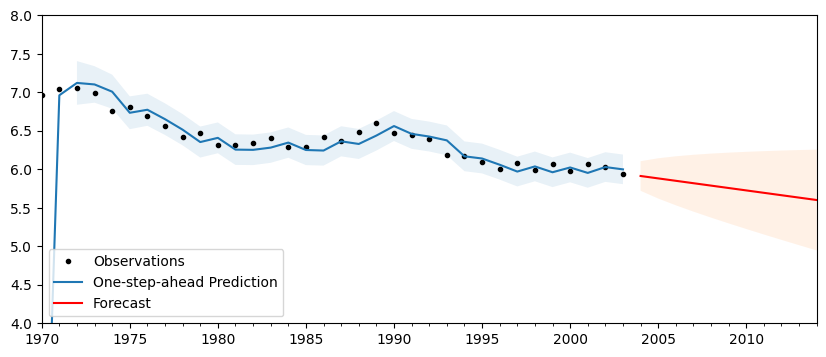

In [6]:
fig, ax = plt.subplots(figsize=(10,4))

# Plot the results
df['lff'].plot(ax=ax, style='k.', label='Observations')
predict.predicted_mean.plot(ax=ax, label='One-step-ahead Prediction')
predict_ci = predict.conf_int(alpha=0.05)
predict_index = np.arange(len(predict_ci))
ax.fill_between(predict_index[2:], predict_ci.iloc[2:, 0], predict_ci.iloc[2:, 1], alpha=0.1)

forecast.predicted_mean.plot(ax=ax, style='r', label='Forecast')
forecast_ci = forecast.conf_int()
forecast_index = np.arange(len(predict_ci), len(predict_ci) + len(forecast_ci))
ax.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], alpha=0.1)

# Cleanup the image
ax.set_ylim((4, 8));
legend = ax.legend(loc='lower left');

### References

    Commandeur, Jacques J. F., and Siem Jan Koopman. 2007.
    An Introduction to State Space Time Series Analysis.
    Oxford ; New York: Oxford University Press.

    Durbin, James, and Siem Jan Koopman. 2012.
    Time Series Analysis by State Space Methods: Second Edition.
    Oxford University Press.